# Author information

### Created on: 291020; Updated: 101120
### Author: Issac Goh
### Proof readers: Simone Webb , Mariana Quiroga Londoño

### Description of this tutorial and the logistic regression approach

* The following tutorial describes a method for integrating data by label transfering based on ridge regulariased logistic regression. This approach enables us to fit a model on the annotated training/landscape/reference dataset to predict labels of a new dataset.  

* Logistic regression can (1) be used to classify samples, (2) use different types of data (continuous and descrete measurements)and (3) also be used to assess what variables are useful for classifying samples.

# 1 - Preparation

# Import modules

In [1]:
import sys
import subprocess

#import pkg_resources
#required = {'harmonypy','sklearn','scanpy','pandas', 'numpy', 'bbknn', 'scipy', 'matplotlib', 'seaborn' ,'scipy'}
#installed = {pkg.key for pkg in pkg_resources.working_set}
#missing = required - installed
#if missing:
#    print("Installing missing packages:" )
#    print(missing)
#    python = sys.executable
#    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

%matplotlib inline
from collections import Counter
from collections import defaultdict
import scanpy as sc
import pandas as pd
import pickle as pkl
import numpy as np
from bbknn import bbknn
import scipy
import matplotlib.pyplot as plt
import re
import glob
import os
import sys
from geosketch import gs
from numpy import cov
import scipy.cluster.hierarchy as spc
import seaborn as sns; sns.set(color_codes=True)
from sklearn.linear_model import LogisticRegression
import sklearn
import harmonypy as hm
from pathlib import Path

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')
sc.logging.print_versions()

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.17.1 scipy==1.4.1 pandas==1.0.5 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


# Data loading - create the hybrid dataset containing categories of interest

## The below block is the only variable assignment (only block user should edit)

In [2]:
# Introduce variables
# Note that this script expects raw data to be in "non-batch-corrected" adata.raw.X. 

# Required: Introduce the path you'd like to save figures or data to 
save_path = "/Users/b8058304/Documents/PhD_work/Coding/useful_scripts/lr_test/figures/"

# Required: Name of first object
data1 = "_YS_train"
# Provide path to obj1 // landscape/training data
Object1 = "/Users/b8058304/Documents/PhD_work/Coding/liver/data/ys_total_annotation_20191127.h5ad"
# Provide categorical to join between datasets
cat1 = "cell.labels"

# Required: Name of second object
data2 = "_YS_predicted"
# Provide path to obj2 // prediction/projection data
Object2 = "/Users/b8058304/Documents/PhD_work/Coding/liver/data/ys_total_annotation_20191127.h5ad"
# Provide categorical to join between datasets
cat2 = "cell.labels"

# Required: LR Model Options
penalty='l2' 
sparcity=0.2

# Optional: Batch correction options (this is for correction of eventual combined dataset for data1 and data2)
# If you do not have a batch variable for either data1 or data2, please add a "filler" column in the relevent adata.obs
# for the purposes of batch_correction and batch args below.
# e.g., adata.obs["whatever"] = "something"; batch="whatever"
batch_correction = "Harmony" # Will accept Harmony, BBKNN or False as options
batch = ["orig.ident", "fetal.ids"] # Will accept any batch categorical. Comma space a batch categorical for each dataset. Position 1 is for data1, position 2 is for data2

# Optional: miscellaneous Options.   
subsample_train = False # Samples the training data to the smallest fraction (highly dependent on resolution of input celltype categorical). This corrects for proportional differences between celltype labels of interest in the training data. E.g., training data has 50,000 B cells, 20,000 T cells and 100 HSCs. This function will subsample all training to 100 cells per cell type.  
train_x = 'X_pca' # Define the resource to train and predict on, PCA, X or UMAP (#if you wish to use gene expression, train_x = 'X')
remove_effect_of_custom_gene_list = 'NA' # "./cell_cycle_genes.csv" #remove a custom list of genes from just the variable genes to compute PCA from. Your .csv should have HGNC gene names in the first column to be read in as a vector, any column name is fine.
use_raw = True # Do you want to use adata.raw.X (recommended)

# 2 - Pre-processing data

# Combine and pre-process data to match correlations across PCA

In [3]:
# Check if filepaths are good
if not os.path.exists(save_path):
    os.makedirs(save_path)
    
if (Path(Object1).is_file() & Path(Object2).is_file()):
    print("adata file paths detetcted, proceeding to load")
    adata = sc.read(Object1)
    adata2 =  sc.read(Object2)
else: 
    raise TypeError("one or more .h5ad paths cannot be accessed")

# altering scanpy setting so that we can save it to our defined directory
sc._settings.ScanpyConfig(figdir=save_path)

# Combine and pre-process data to match correlations across PCA

# Module to detect shape mismatch and alternatively rebuild adata
if(use_raw==True):
    print('option detected to use raw data, proceeding to check if raw exists and if it matches data.X')
    if (hasattr(adata.raw, "X")):
        try: adata.X =  adata.raw.X  ; print('no mismatch in shape for adata detected')
        except: print("adata.X shape mismatched with adata.raw.X, proceeding to re-build data") ; adata = adata.raw.to_adata()
    else:
        print("no raw data detected in adata! proceeding to create raw partition from adata.X")
        adata.raw = adata
        
    if (hasattr(adata2.raw, "X")):
        try: adata2.X = adata2.raw.X ; print('no mismatch in shape for adata2 detected')
        except: print("adata2.X shape mismatched with adata.raw.X, proceeding to re-build data") ; adata2 = adata2.raw.to_adata()
    else:
        print("no raw data detected in adata! proceeding to create raw partition from adata.X")
        adata2.raw = adata2
            
# Define intersecting genes between datasets
adata_genes = list(adata.var.index)
adata2_genes = list(adata2.var.index)
keep_SC_genes = list(set(adata_genes) & set(adata2_genes))
print("keep gene list = " , len(keep_SC_genes), "adata1 gene length = ", len(adata_genes) , "adata2 gene length = ", len(adata2_genes) )

# Remove non-intersecting genes (this step will remove cite-seq data if training data is pure RNA seq)
adata_intersect1 = adata[:, keep_SC_genes]
adata = adata_intersect1
adata_intersect2 = adata2[:, keep_SC_genes]
adata2 = adata_intersect2

# Optional subsampling of training data to 
if(subsample_train == True):
    data = adata.obs
    data = data.sample(frac=1).groupby('corr_concat').head(min(adata.obs.groupby(cat1).size()))
    keep = data.index
    adata = adata[adata.obs.index.isin(keep)]

# Create a common batch column and do simple sanity check for batch variables
if not((batch_correction == "False") and (len(batch)>1)):
    print("Batch correction option detected, proceeding to format batch variables")
    batch_var = "lr_batch"
    adata.obs["lr_batch"] = adata.obs[batch[0]]
    adata2.obs["lr_batch"] = adata2.obs[batch[1]]
else: raise TypeError("Batch correction option detected but requires at least one categorical for each dataset!")

# Create a common obs column in both datasets containing the data origin tag
common_cat = "corr_concat" 
adata.obs[common_cat] = adata.obs[cat1].astype(str) + data1
adata2.obs[common_cat] = adata2.obs[cat2].astype(str) + data2
adata.obs = adata.obs.astype('category')
adata2.obs = adata2.obs.astype('category')
concat = adata2.concatenate(adata, join='inner',index_unique=None, batch_categories=None)
adata = concat[:]
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.1, max_mean=4)
sc.pp.scale(adata, zero_center=True, max_value=None, copy=False)

# Optionally remove genes of known confounding effect from variable list
if not (Path(remove_effect_of_custom_gene_list).is_file()):
    print("Custom gene list option is not selected or path is not readbale, proceeding with no variable removal")
else: 
    print("Custom gene removal list detected, proceeding to remove intersect from variable genes")
    regress_list = pd.read_csv(remove_effect_of_custom_gene_list)
    regress_list = regress_list.iloc[:, 0]
    adata.var["highly_variable"][adata.var.index.isin(regress_list)] = "False"
    
# Now compute PCA
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')

# Batch correction options
# The script will test later which Harmony values we should use
if not(batch_correction == "False"):
    sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)    
if(batch_correction == "Harmony"):
    print("Commencing harmony")
    # Create hm subset
    adata_hm = adata[:]
    # Set harmony variables
    data_mat = np.array(adata_hm.obsm["X_pca"])
    meta_data = adata_hm.obs
    vars_use = [batch_var]
    # Run Harmony
    ho = hm.run_harmony(data_mat, meta_data, vars_use)
    res = (pd.DataFrame(ho.Z_corr)).T
    res.columns = ['X{}'.format(i + 1) for i in range(res.shape[1])]
    # Insert coordinates back into object
    adata_hm.obsm["X_pca_back"]= adata_hm.obsm["X_pca"][:]
    adata_hm.obsm["X_pca"] = np.array(res)
    # Run neighbours
    sc.pp.neighbors(adata_hm, n_neighbors=15, n_pcs=50)
    adata = adata_hm[:]
elif(batch_correction == "BBKNN"):
    print("Commencing BBKNN")
    sc.external.pp.bbknn(adata, batch_key=batch_var, approx=True, metric='angular', copy=False, n_pcs=50, trim=None, n_trees=10, use_faiss=True, set_op_mix_ratio=1.0, local_connectivity=15) 
    
print("adata1 and adata2 are now combined and preprocessed in 'adata' obj - success!")

adata file paths detetcted, proceeding to load
option detected to use raw data, proceeding to check if raw exists and if it matches data.X
no raw data detected in adata! proceeding to create raw partition from adata.X
no raw data detected in adata! proceeding to create raw partition from adata.X
keep gene list =  32084 adata1 gene length =  32084 adata2 gene length =  32084


Trying to set attribute `.obs` of view, copying.


Batch correction option detected, proceeding to format batch variables


Trying to set attribute `.obs` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Or pass `index_unique!=None` to `.concatenate`.
Or pass `index_unique!=None` to `.concatenate`.


normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


    finished (0:00:02): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:06)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Custom gene list option is not selected or path is not readbale, proceeding with no variable removal
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 50


/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics f

    finished (0:00:08)
Commencing harmony


2020-11-20 17:13:01,431 - harmonypy - INFO - Iteration 1 of 10
2020-11-20 17:13:06,708 - harmonypy - INFO - Iteration 2 of 10
2020-11-20 17:13:12,420 - harmonypy - INFO - Iteration 3 of 10
2020-11-20 17:13:18,261 - harmonypy - INFO - Iteration 4 of 10
2020-11-20 17:13:21,781 - harmonypy - INFO - Iteration 5 of 10
2020-11-20 17:13:24,437 - harmonypy - INFO - Iteration 6 of 10
2020-11-20 17:13:27,256 - harmonypy - INFO - Iteration 7 of 10
2020-11-20 17:13:30,112 - harmonypy - INFO - Iteration 8 of 10
2020-11-20 17:13:32,459 - harmonypy - INFO - Iteration 9 of 10
2020-11-20 17:13:34,605 - harmonypy - INFO - Iteration 10 of 10
2020-11-20 17:13:36,490 - harmonypy - INFO - Stopped before convergence
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


computing neighbors
    using 'X_pca' with n_pcs = 50


/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnost

    finished (0:00:05)
adata1 and adata2 are now combined and preprocessed in 'adata' obj - success!


# 3 - Prepare and run LR model 

Summary of logistic regression model used (MQL to add reference/image here)

* L2 regression is a technique to ensure we do not overfit our training data. 

* It desensitise the model to the training data by minimising the sum of the squared residuals (RSS) + $\lambda$*slope^2 (i.e. Lambda times the sum of all squared parameters, except for the y-intercept)

* Slope^2 adds a penalty to the traditional Least squares method and lamnda determines how strong/severe that penalty is.

* If we didn’t add that amount of bias that the penalty generates, there would be a large variance in our data.

* Thus, helps to reduce the variance by “shrinking parameters” and by making the predictions “less sensitive “to them.

* When the sample sizes are relatively small, then Ridge Regression can improve predictions made from new data (i.e. reduce variance) by making the predictions less sensitive to the training data.

* Regression makes assumption that there is noise - aims to reduce noise (so you don't get dual positive assignment), by reducing lambda to zero for noise. 

In [4]:
# This function require compute power, will take a while 

def LR_compare(adata, train_x, train_label, subset_predict, subset_train, penalty=penalty, sparcity=sparcity, 
               col_name='predicted'):

    # adata - training+prediction adata object (combined). Pre-processed already
    # sparsity - larger sparsity, more bins, more conservative predictions, less accurate. Low sparist for clean output
                # A value of 0.2 is reasonable for L2 ridge regression
    # penalty - acts as buffer for assigning bins too harshly
    # train_x - arg refers to where you would like to derive your training reference from, i.e., GEX (X) or/elif.
                # PCA/UMAP in obsm. The two 'if' statements below handle train_x differently based on this
                # Based on train_x, the loops below compute 'train_label' (cell type values in training/landscape data) 
                # and 'predict_x'(prediction data equivalent of train_x)
    # train_label - cell type values in training/landscape data
    # subset_predict - mandatory subset of predict_x which contains metadata for expression
    # subset_train - mandatory subset of train_x which contains metadata for expression
    
    # Redefine LR parameters 'penalty' and 'sparsity' if you would like to deviate from defaults set above
    
    # Assign 'lr' as sklearn logistic regression func, with penalty and sparsity defined above
    lr = LogisticRegression(penalty = penalty, C = sparcity)

    if train_x == 'X':
        # Define training parameters
        train_label = adata.obs[common_cat].values
        train_label = train_label[subset_train]
        train_x = adata.X,
        # Define prediction parameters
        predict_x = train_x
        train_x = train_x[subset_train, :]
        predict_x = train_x
        predict_x = predict_x[subset_predict]

    elif train_x in adata.obsm.keys():
        # Define training parameters
        train_label = adata.obs[common_cat].values
        train_label = train_label[subset_train]
        train_x = adata.obsm[train_x]
        predict_x = train_x
        train_x = train_x[subset_train, :]
        # Define prediction parameters
        predict_x = predict_x[subset_predict]
        predict_x = pd.DataFrame(predict_x)
        predict_x.index = adata.obs[subset_predict].index

    # Train predictive model using user defined partition labels (train_x ,train_label, predict_x)
    model = lr.fit(train_x, train_label)
    lr.fit(train_x, train_label)
    predict = lr.predict_proba(predict_x)

    # Create prediction table and map to adata.obs (in adata.obs["predict"] in the combined object), for the cells that
    # are in predict dataset
    predict = lr.predict(predict_x)
    predict = pd.DataFrame(predict)
    predict.index = adata.obs[subset_predict].index
    adata.obs[col_name] = adata.obs.index
    adata.obs[col_name] = adata.obs[col_name].map(predict[0])

# Function to plot heatmap by percentage
def plot_df_heatmap(df, cmap='viridis', title=None, figsize=(7, 7), rotation=90, save=None, **kwargs):
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(df, cmap=cmap, aspect='auto', **kwargs)
    if 0 < rotation < 90:
        horizontalalignment = 'right'
    else:
        horizontalalignment = 'center'
    plt.xticks(
        range(len(df.columns)),
        df.columns,
        rotation=rotation,
        horizontalalignment=horizontalalignment,
    )
    plt.yticks(range(len(df.index)), df.index)
    if title:
        fig.suptitle(title)
    #fig.colorbar(im)
    if save:
        plt.savefig(fname=save, bbox_inches='tight', pad_inches=0.1)

# Plot probability table by html
def cross_table(adata, x, y, normalise=None, highlight=False, subset=None):                                                                                                                                                                                              
    """Make a cross table comparing two categorical annotations
    """
    x_attr = adata.obs[x]
    y_attr = adata.obs[y]
    if subset is not None:
        x_attr = x_attr[subset]
        y_attr = y_attr[subset]
    crs_tbl = pd.crosstab(x_attr, y_attr)
    if normalise == 'x':
        x_sizes = x_attr.groupby(x_attr).size().values
        crs_tbl = (crs_tbl.T / x_sizes).round(2).T
    elif normalise == 'y':
        y_sizes = x_attr.groupby(y_attr).size().values
        crs_tbl = (crs_tbl / y_sizes).round(2)
    if highlight:
        return crs_tbl.style.background_gradient(cmap='viridis', axis=0)
    return crs_tbl

## Now the LR magic happens... - Logistic Regression pre-face

In [5]:
# Define the separator category in the column of interest, this works by partial matches and enables a-symmetric 
# comparisons
Data1_group = data1
Data2_group = data2
# Define the common .obs column between concatinated data
common_cat = "corr_concat"

# This block defines subset_predict and subset_train and also runs LR_compare function
group1 = (adata.obs[common_cat][adata.obs[common_cat].str.contains(Data1_group)]).unique()
group1 = list(group1)
group2 = (adata.obs[common_cat][adata.obs[common_cat].str.contains(Data2_group)]).unique()
group2 = list(group2)
subset_predict = np.array(adata.obs[common_cat].isin(group2))
subset_train = np.array(adata.obs[common_cat].isin(group1))
train_label = (adata.obs[common_cat][adata.obs[common_cat].isin(group1)]).values

LR_compare(adata, train_x, train_label, subset_predict, subset_train, sparcity=sparcity, col_name='predicted')

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    http

In [6]:
# Plotting purposes - Subset data to only contain prediction data with new predicted labelså

# Make adata the predicted data with projected annotations in adata.obs["predicted"]. "corr_concat" contains old 
# cell.labels and dataset name combined 
common_cat = "corr_concat"
adata_concat = adata[:]
adata = adata[adata.obs["predicted"].isin(group1)]
adata = adata[adata.obs["corr_concat"].isin(group2)]

# 4 - Plot the LR model output

## Probability table and heatmap

In [7]:
# The results, are displayed in a python notebook or rendered as a html (just for quick visualisation, not saving)
# This table represents probability (binary cell type assignment) - numbers represent number of cells
# Columns contain number of original cells from adata2 that are now labelled using the training dataset, adata1
# (as shown on y axis)
crs_tbl = cross_table(adata, x = 'predicted', y = common_cat, highlight = True)
crs_tbl

corr_concat,DC progenitor_YS_predicted,Early mast cell_YS_predicted,Endothelium_YS_predicted,Erythroid AB_YS_predicted,Erythroid EZ_YS_predicted,Erythroid M_YS_predicted,ILC precursor_YS_predicted,Lymphoid progenitor_YS_predicted,MEMP_YS_predicted,Monocyte_YS_predicted,Myeloid progenitor_YS_predicted,NK early_YS_predicted,yolk sac Macrophage II_YS_predicted,yolk sac Macrophage I_YS_predicted,yolk sac progenitor/MPP_YS_predicted
predicted,,,,,,,,,,,,,,,
DC progenitor_YS_train,51,0,0,0,0,0,0,15,1,0,0,0,4,0,1
Early mast cell_YS_train,0,130,0,0,0,0,0,0,2,0,0,0,0,0,0
Endothelium_YS_train,0,0,160,0,0,0,0,0,0,0,0,0,0,0,0
Erythroid AB_YS_train,0,0,0,744,92,0,0,0,0,0,0,0,0,0,0
Erythroid EZ_YS_train,0,0,0,148,1071,14,0,0,13,0,0,0,0,0,0
Erythroid M_YS_train,0,0,0,0,3,256,0,0,1,0,0,0,1,1,0
ILC precursor_YS_train,2,0,0,0,0,0,25,0,0,0,0,0,0,0,0
Lymphoid progenitor_YS_train,11,0,0,0,0,0,0,143,0,0,0,2,20,2,3
MEMP_YS_train,0,3,0,0,1,5,0,0,101,0,0,0,1,0,2


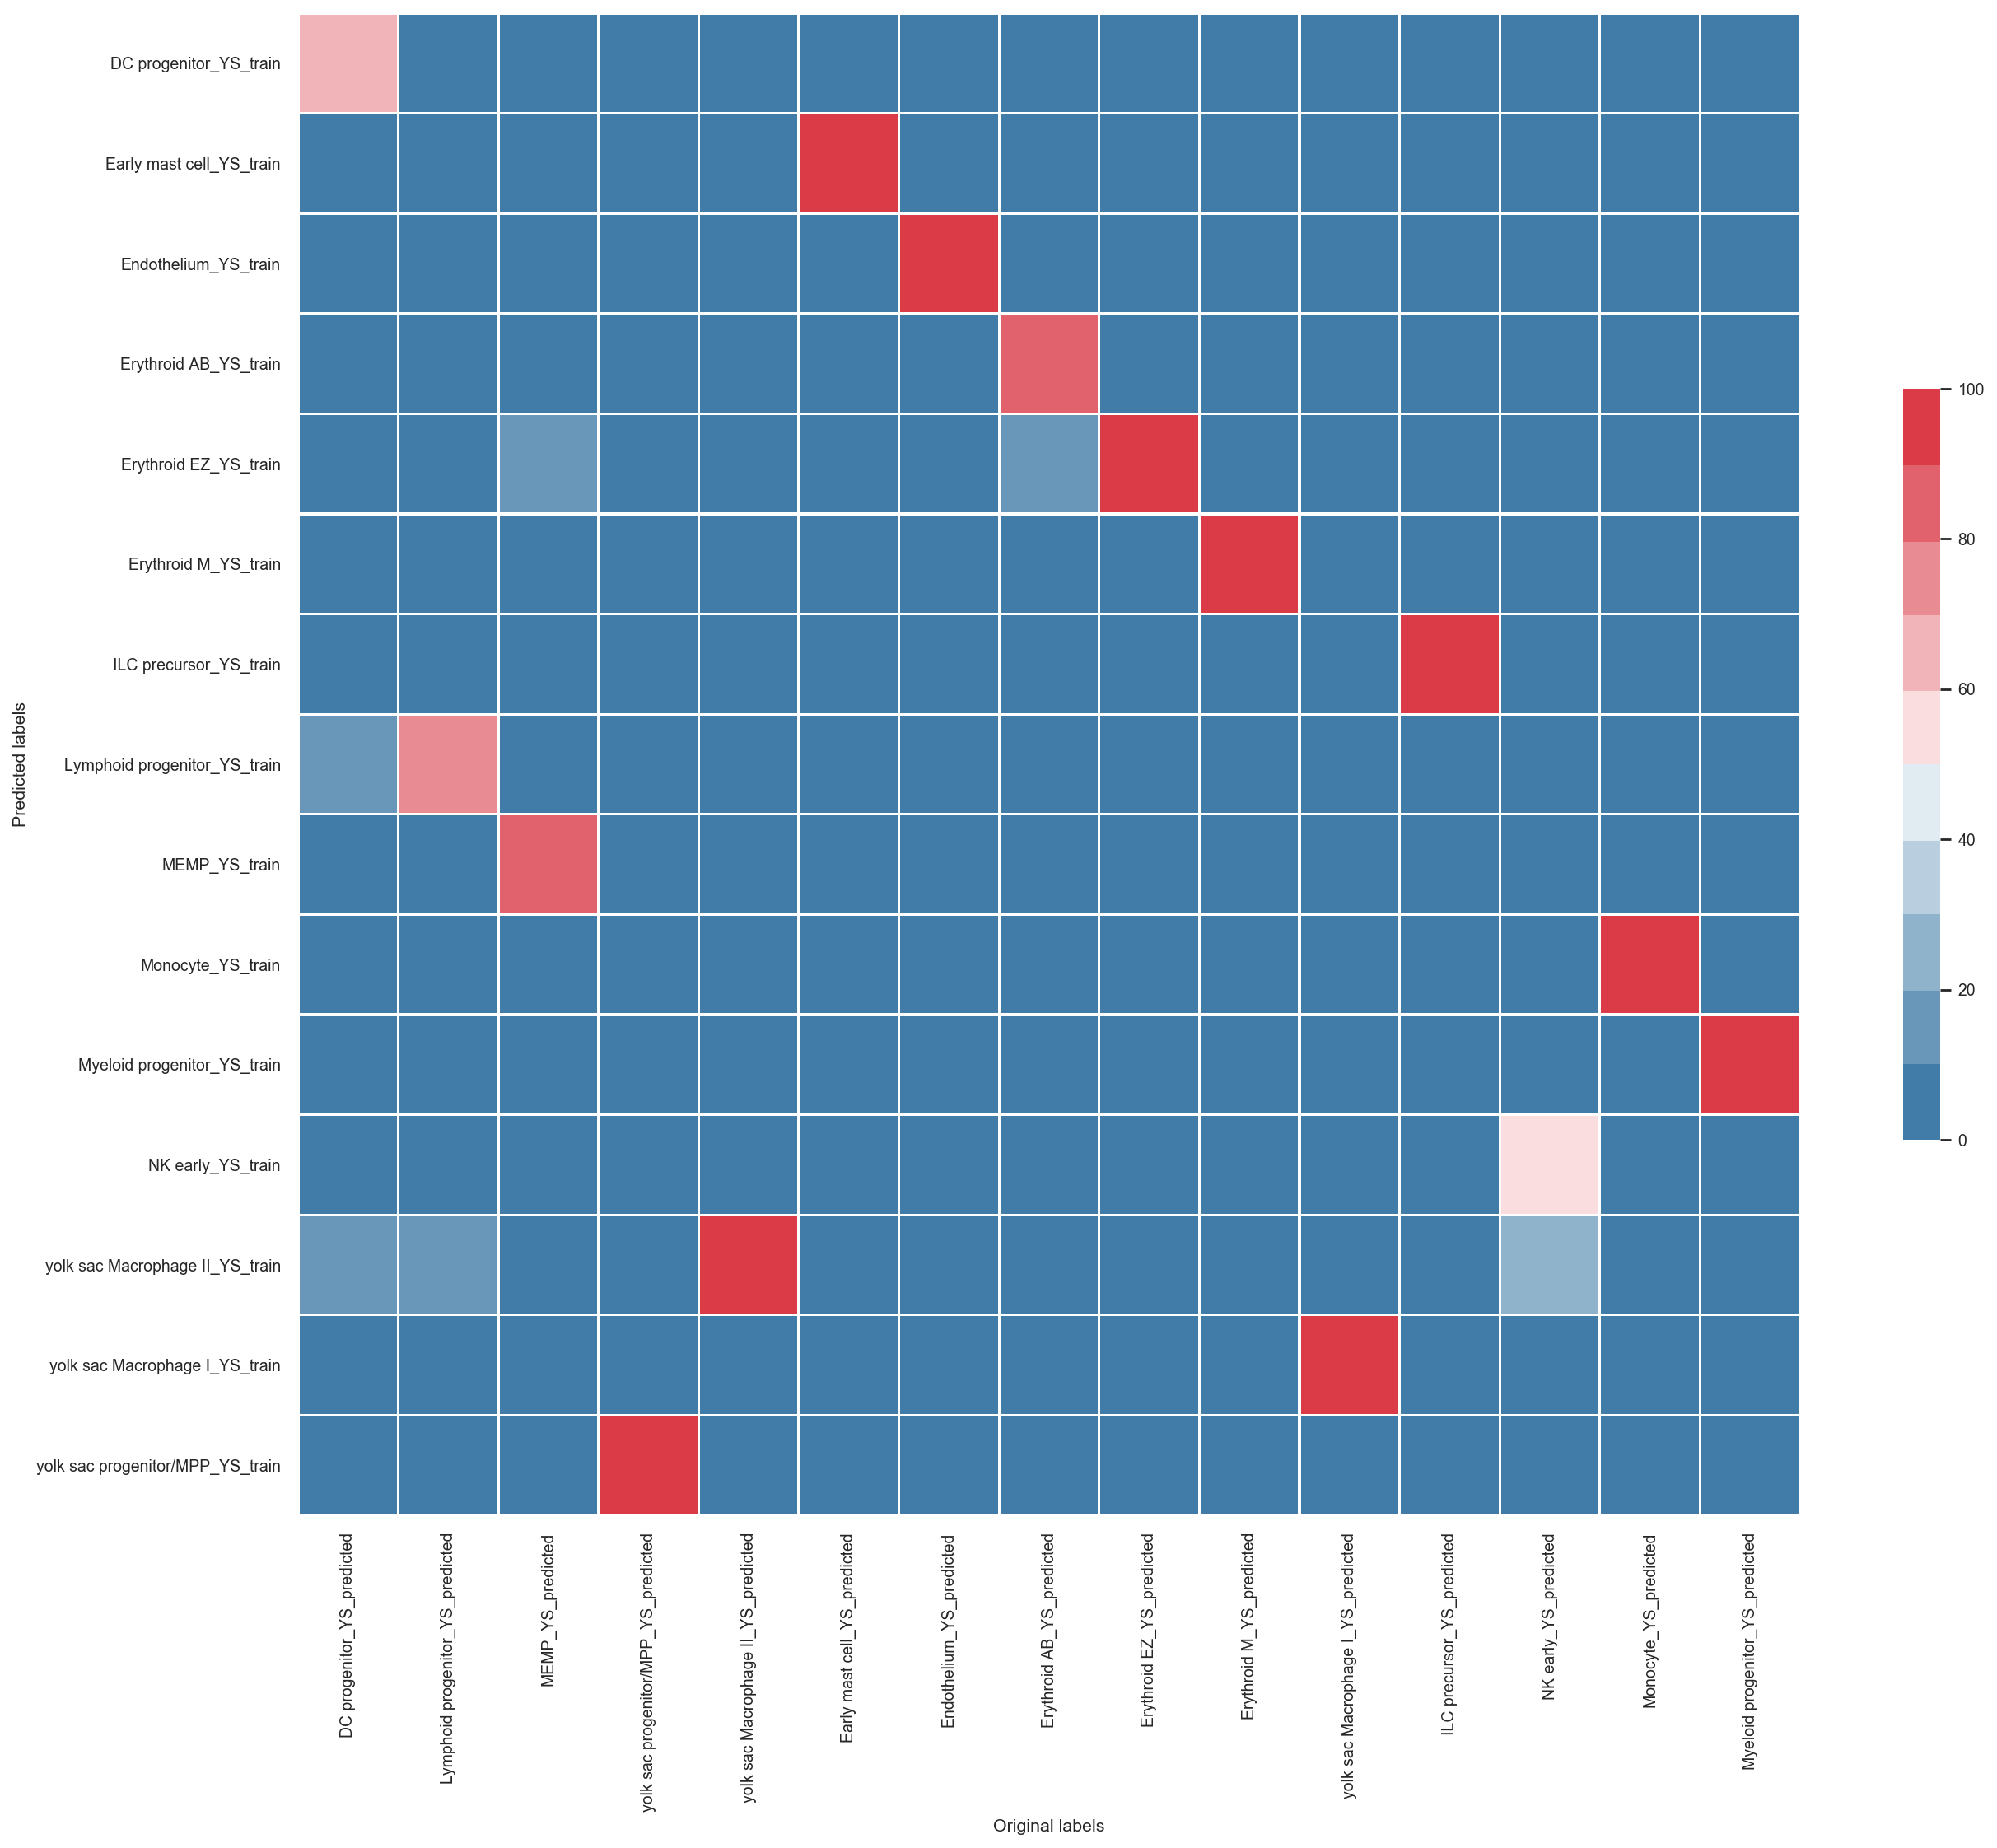

In [8]:
x = 'predicted'
y = common_cat

y_attr = adata.obs[y]
x_attr = adata.obs[x]
crs = pd.crosstab(x_attr, y_attr)
crs_tbl = crs
for col in crs_tbl :
    crs_tbl[col] = crs_tbl[col].div(crs_tbl[col].sum(axis=0)).multiply(100).round(2)
    
# Sort df columns by rows
crs_tbl = crs_tbl.sort_values(by =list(crs_tbl.index), axis=1,ascending=False)

# Plot_df_heatmap(crs_tbl, cmap='coolwarm', rotation=90, vmin=20, vmax=70)
pal = sns.diverging_palette(240, 10, n=10)
plt.figure(figsize=(20,15))
sns.set(font_scale=0.8)
g = sns.heatmap(crs_tbl, cmap=pal, vmin=0, vmax=100, linewidths=1, center=50, square=True, cbar_kws={"shrink": 0.5})
plt.xlabel("Original labels")
plt.ylabel("Predicted labels")
plt.savefig(save_path + "/LR_predictions.pdf")
crs_tbl.to_csv(save_path + "/pre-freq_LR_predictions_supp_table.csv")

In [9]:
prop = adata.obs.groupby('predicted').count()
prop['percentage'] = (prop.iloc[:,6]/prop.iloc[:,6].sum())*100
prop = prop['percentage']
prop.to_csv(save_path + "/pre-freq_predicted_prop.csv")
prop

predicted
DC progenitor_YS_train               2.977233
Early mast cell_YS_train             0.350263
Endothelium_YS_train                 0.000000
Erythroid AB_YS_train                0.000000
Erythroid EZ_YS_train                2.276708
Erythroid M_YS_train                 0.175131
ILC precursor_YS_train               0.000000
Lymphoid progenitor_YS_train        25.569177
MEMP_YS_train                       18.038529
Monocyte_YS_train                    0.175131
Myeloid progenitor_YS_train         10.507881
NK early_YS_train                    0.175131
yolk sac Macrophage II_YS_train      4.203152
yolk sac Macrophage I_YS_train       0.175131
yolk sac progenitor/MPP_YS_train    35.376532
Name: percentage, dtype: float64

# 5 - Redistribute the predictions using additive assignment

In [10]:
# Optional clustering 
res = 5
key_add = 'leiden'
adata.obs[key_add] = "nan"
sc.tl.leiden(adata, resolution= res, key_added= key_add, random_state=26, n_iterations=-1)

Trying to set attribute `.obs` of view, copying.


running Leiden clustering
    finished (0:00:02)


In [11]:
cluster_prediction = "clus_prediction"
clusters_reassign = "leiden"
lr_predicted_col = 'predicted'

In [12]:
adata.obs[cluster_prediction] = adata.obs.index
for z in adata.obs[clusters_reassign].unique():
    df = adata.obs
    df = df[(df[clusters_reassign].isin([z]))]
    df_count = pd.DataFrame(df[lr_predicted_col].value_counts())
    freq_arranged = df_count.index
    cat = freq_arranged[0]
    df.loc[:,cluster_prediction] = cat
    adata.obs.loc[adata.obs[clusters_reassign] == z, [cluster_prediction]] = cat

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


# 6 - Replot LR output (probability table and heatmap) based on freq redistributed proportions

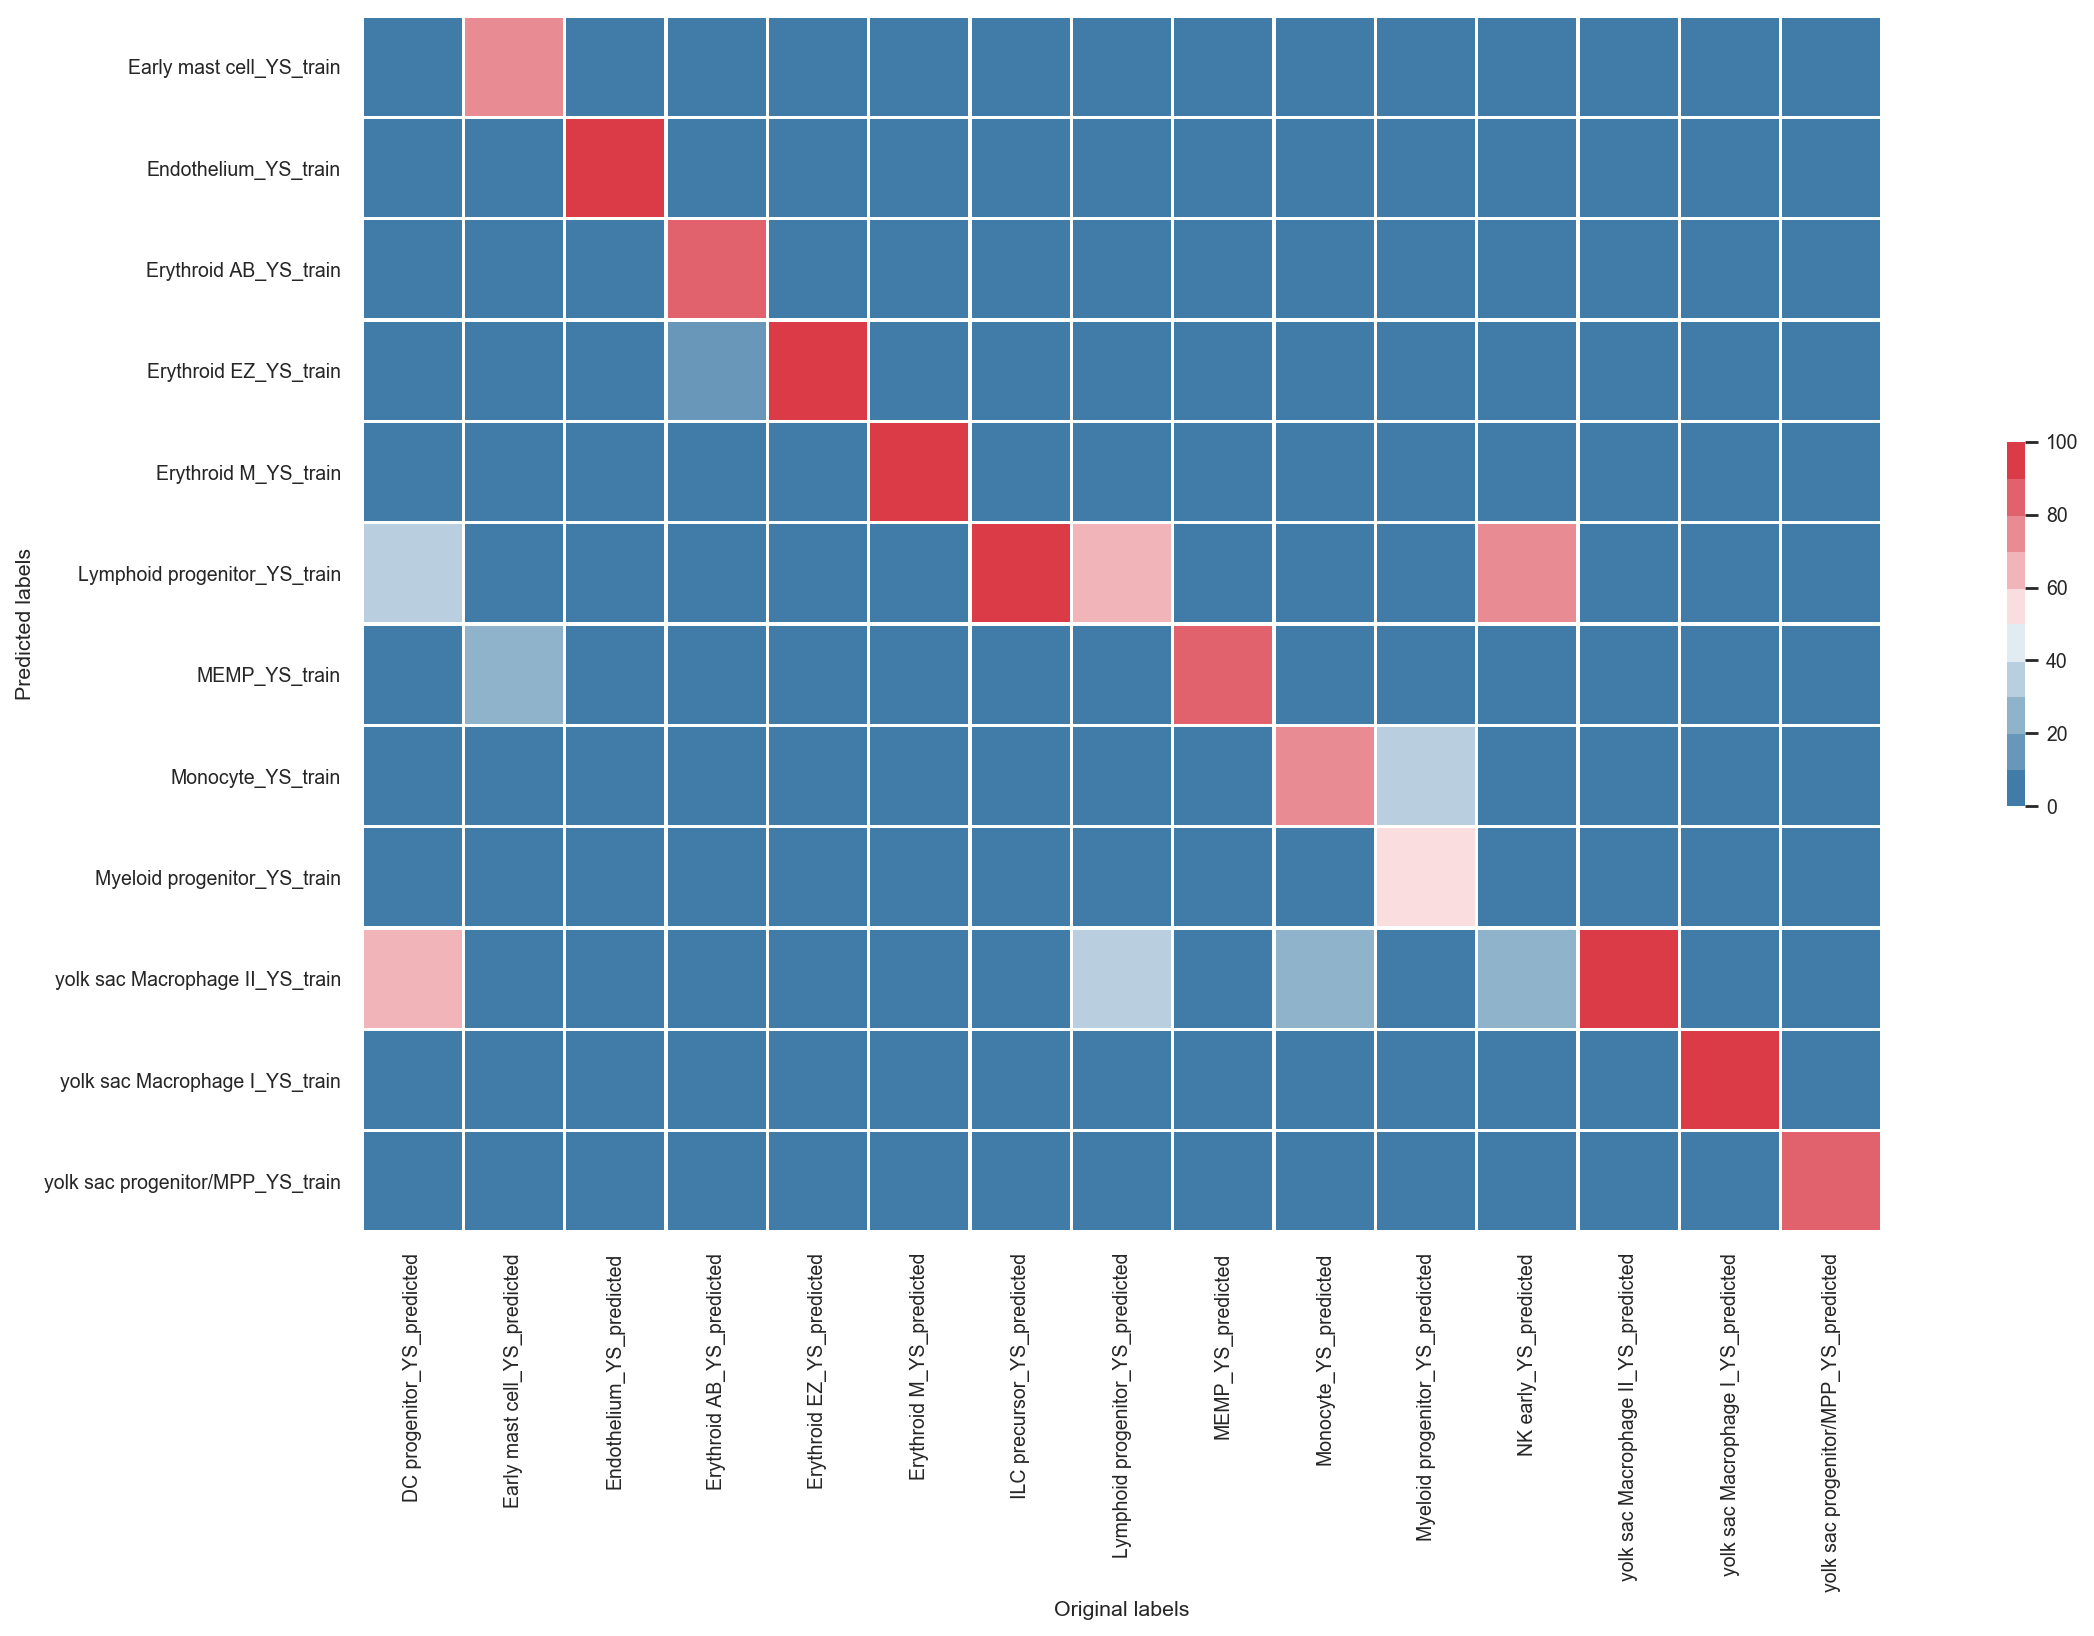

In [13]:
# Create a concat col for old + predicted annots
adata.obs['annot_clus_prediction_concat'] = adata.obs[cat1].astype(str) + "_" + adata.obs['clus_prediction'].astype(str)

x='clus_prediction'
y = common_cat

y_attr = adata.obs[y]
x_attr = adata.obs[x]
crs = pd.crosstab(x_attr, y_attr)
crs_tbl = crs
for col in crs_tbl :
    crs_tbl[col] = crs_tbl[col].div(crs_tbl[col].sum(axis=0)).multiply(100).round(2)

#plot_df_heatmap(crs_tbl, cmap='coolwarm', rotation=90, vmin=20, vmax=70)
pal = sns.diverging_palette(240, 10, n=10)
plt.figure(figsize=(20,10))
sns.set(font_scale=0.8)
g = sns.heatmap(crs_tbl, cmap=pal, vmin=0, vmax=100, linewidths=1, center=50, square=True, cbar_kws={"shrink": 0.3})
plt.xlabel("Original labels")
plt.ylabel("Predicted labels")
plt.savefig(save_path + "/LR_predictions_consensus.pdf")
crs_tbl.to_csv(save_path + "/post-freq_LR_predictions_consensus_supp_table.csv")

In [14]:
prop = adata.obs.groupby('clus_prediction').count()
prop['percentage'] = prop.iloc[:,6]/prop.iloc[:,6].sum()
prop = prop['percentage']
prop.to_csv(save_path + "/post-freq_predicted_leiden_consensus_prop.csv")
prop

clus_prediction
Early mast cell_YS_train            0.001751
Endothelium_YS_train                0.000000
Erythroid AB_YS_train               0.000000
Erythroid EZ_YS_train               0.007005
Erythroid M_YS_train                0.001751
Lymphoid progenitor_YS_train        0.213660
MEMP_YS_train                       0.196147
Monocyte_YS_train                   0.043783
Myeloid progenitor_YS_train         0.084063
yolk sac Macrophage II_YS_train     0.124343
yolk sac Macrophage I_YS_train      0.001751
yolk sac progenitor/MPP_YS_train    0.325744
Name: percentage, dtype: float64

# 7 - Assess confidence in frequency redistribtion

## This UMAP shows the predictions for the dataset pre and post frequency redistribution

computing UMAP


/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


    finished (0:00:04)


... storing 'corr_concat' as categorical
... storing 'lr_batch' as categorical
... storing 'predicted' as categorical
... storing 'clus_prediction' as categorical
... storing 'annot_clus_prediction_concat' as categorical


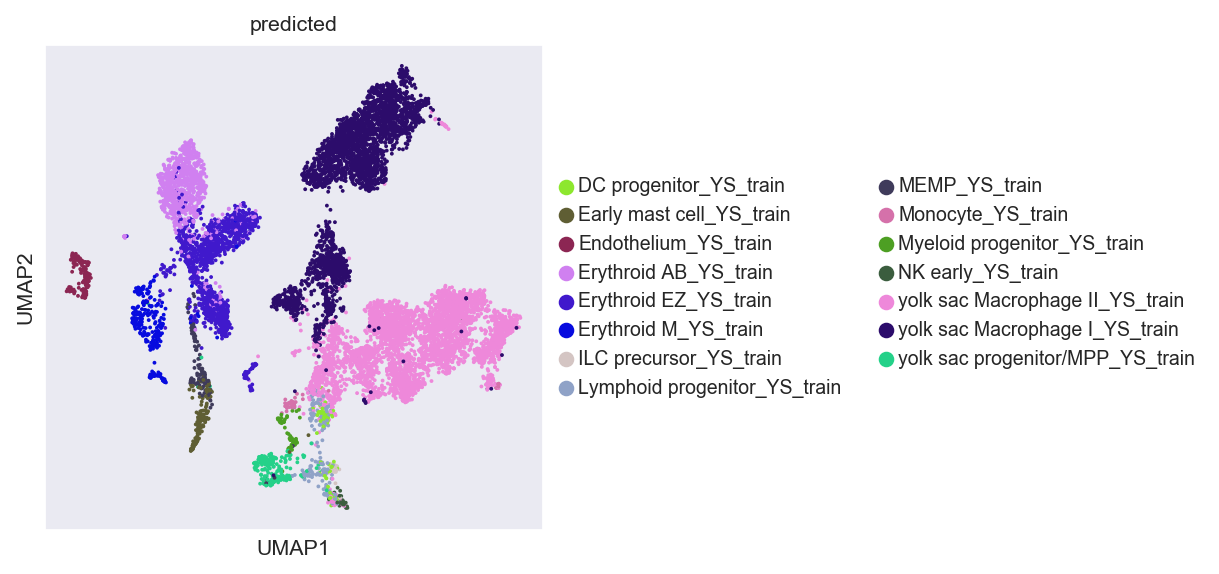

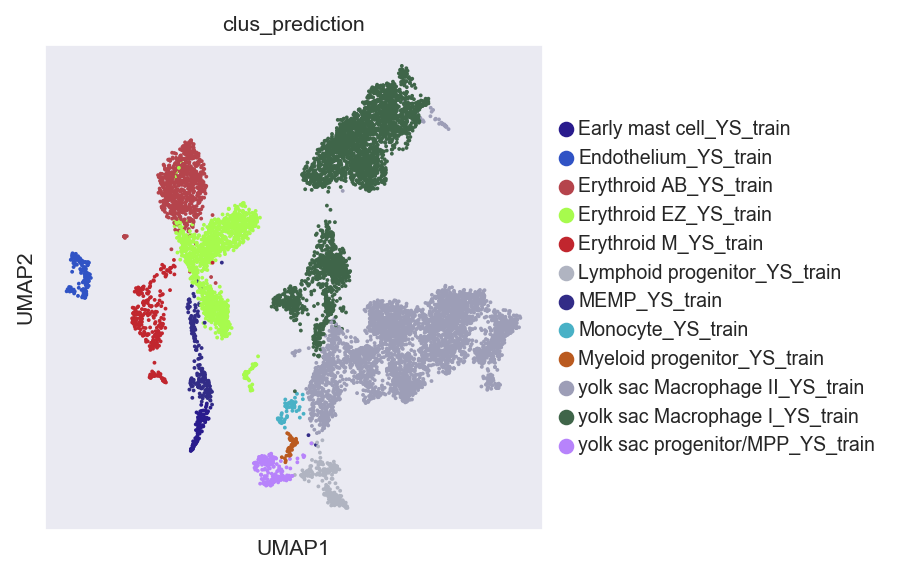

In [15]:
# Generate a umap to view your current data
sc.tl.umap(adata)

def generate_colors(col_required):
    import random
    number_of_colors = col_required
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                 for i in range(number_of_colors)]
    return list(color)

col = generate_colors(len(adata.obs["predicted"].unique()))
sc.pl.umap(adata, color='predicted', palette = col, save = "prediction_umap.pdf")

col = generate_colors(len(adata.obs["clus_prediction"].unique()))
sc.pl.umap(adata, color='clus_prediction', palette = col, save = "clus_prediction_umap.pdf")

## Have a look if some cell type categories have been removed after frequency redistribution

3 labels were omitted during the consensus redistribution step! Please check if these labels are expected to be significantly available in the prediction dataset! Missin labels are::
################################
{'ILC precursor_YS_train', 'NK early_YS_train', 'DC progenitor_YS_train'}


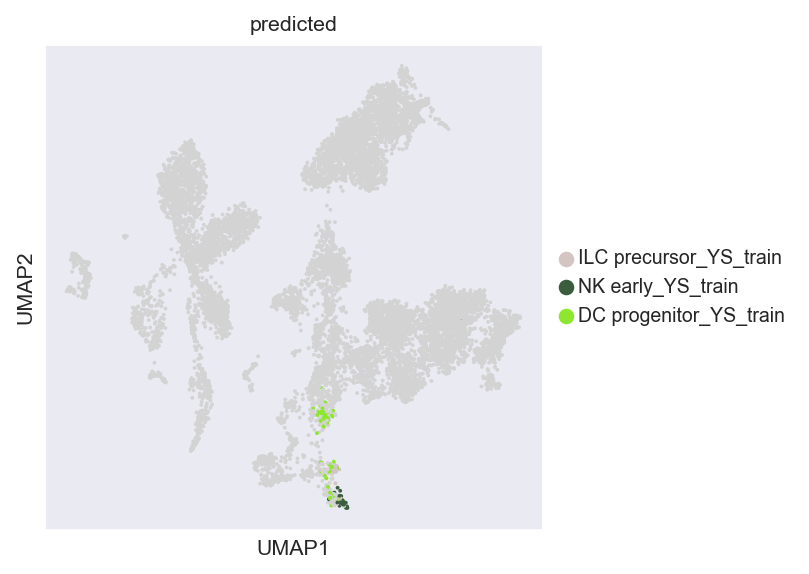

In [16]:
# Are any celltypes removed between prediction and cluster consensus step?
prediction_set = list(adata.obs['predicted'].unique())
clust_prediction_set = list(adata.obs['clus_prediction'].unique())
non_intersect = set(prediction_set) ^ set(clust_prediction_set)
non_intersect = non_intersect.intersection(prediction_set)

if (len(non_intersect)>0):
    print(str(len(non_intersect)) + " labels were omitted during the consensus redistribution step! Please check if these labels are expected to be significantly available in the prediction dataset! Missin labels are::" )
    print("################################")
    print(non_intersect)
    
    # plot umap coloring only labels that were lost in consensus step
    sc.pl.umap(adata,color="predicted",groups=non_intersect, save = "freq_redistribution_omitted_labels_umap.pdf")
else: print("No labels were omitted!")

In [17]:
# calculate Rand and MI
rand = sklearn.metrics.adjusted_rand_score(list(adata.obs['predicted']), list(adata.obs['clus_prediction']))
mi = sklearn.metrics.adjusted_mutual_info_score(list(adata.obs['predicted']), list(adata.obs['clus_prediction']), 
                                                average_method='arithmetic')

# test concordance between the predicted labels by cell and the consensus clusters
if ((rand<0.8) | (mi<0.8)):
    print("Your concordance between predicted and consensus leiden labels are weak, please attempt reclustering at higher resolution and running consensus again")
    print("Adj Rand extimate = " + str(rand) + "  " + "Mutual Information score=" + str(mi))
else: 
    print("success")
    print("You have achieved good consensus between predicted labels and consensus leiden labels")
    print("Adj Rand extimate = " + str(rand) + "  " + "Mutual Information score=" + str(mi))

success
You have achieved good consensus between predicted labels and consensus leiden labels
Adj Rand extimate = 0.9186401439855867  Mutual Information score=0.8692069355691093


# Save transferred labels + leiden clusters

In [18]:
df = adata.obs[["predicted", "leiden", "clus_prediction"]]
df = df.rename(columns={"predicted": "pre_freq_clus_prediction", "clus_prediction": "post_freq_clus_prediction"})
df.to_csv(save_path + "/final_lr_metadata_for_adata2.csv")
df

,pre_freq_clus_prediction,leiden,post_freq_clus_prediction
index,,,
F32_yolk sac_Total_FCAImmP7316900_ATCCACCGTGTTTGGT,Lymphoid progenitor_YS_train,33,Lymphoid progenitor_YS_train
F32_yolk sac_Total_FCAImmP7316900_CAGAATCCACTGTTAG,Lymphoid progenitor_YS_train,26,yolk sac Macrophage II_YS_train
F32_yolk sac_Total_FCAImmP7316900_CCATGTCTCAGCTTAG,Lymphoid progenitor_YS_train,33,Lymphoid progenitor_YS_train
F32_yolk sac_Total_FCAImmP7316900_CTACCCAAGCCCGAAA,Lymphoid progenitor_YS_train,33,Lymphoid progenitor_YS_train
F32_yolk sac_Total_FCAImmP7316900_CTTAGGATCACTATTC,Lymphoid progenitor_YS_train,33,Lymphoid progenitor_YS_train
...,...,...,...
F37_yolk sac_Total_FCAImmP7504913_TTTCCTCGTTCCCTTG,Early mast cell_YS_train,37,Early mast cell_YS_train
F37_yolk sac_Total_FCAImmP7504912_GGGAGATCAAGGTGTG,NK early_YS_train,34,Lymphoid progenitor_YS_train
F37_yolk sac_Total_FCAImmP7504912_TAGAGCTTCCTTCAAT,NK early_YS_train,34,Lymphoid progenitor_YS_train
